In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import r2_score


In [2]:
df = pd.read_csv("../Data/perrin-freres-monthly-champagne.csv",
                 index_col="Month",
                 parse_dates=True, skipfooter=2, engine="python")


In [3]:
df.columns = ["Sales"]


In [4]:
df["LogSales"] = np.log(df["Sales"])


In [5]:
df.head()


,Sales,LogSales
Month,,
1964-01-01,2815,7.942718
1964-02-01,2672,7.890583
1964-03-01,2755,7.921173
1964-04-01,2721,7.908755
1964-05-01,2946,7.988204


In [6]:
Ntest = 12
train = df.iloc[:-Ntest]
test = df.iloc[-Ntest:]


In [7]:
# Make supervised dataset
# let's see if we can use T past values to predict the next value

series = df["LogSales"].to_numpy()

T = 12
X = []
Y = []
for t in range(len(series) - T):
    x = series[t:t+T]
    X.append(x)
    y = series[t+T]
    Y.append(y)

X = np.array(X).reshape(-1, T)
Y = np.array(Y)
N = len(X)
print("X.shape:", X.shape, "Y.shape:", Y.shape)


X.shape: (93, 12) Y.shape: (93,)


In [8]:
Xtrain, Ytrain = X[:-Ntest], Y[:-Ntest]
Xtest, Ytest = X[-Ntest:], Y[-Ntest:]

print("Xtrain.shape:", Xtrain.shape, "Ytrain.shape:", Ytrain.shape)
print("Xtest.shape:", Xtest.shape, "Ytest.shape:", Ytest.shape)


Xtrain.shape: (81, 12) Ytrain.shape: (81,)
Xtest.shape: (12, 12) Ytest.shape: (12,)


In [9]:
lr = LinearRegression()
lr.fit(Xtrain, Ytrain)
print("LR train score:", lr.score(Xtrain, Ytrain))


LR train score: 0.8682372095558997


In [10]:
lr.score(Xtest, Ytest)


0.9657520752272788

In [11]:
# Boolean index
train_idx = df.index <= train.index[-1]
test_idx = ~train_idx

train_idx[:T] = False  # first T values are not predictable


In [12]:
# 1-step forecast
df.loc[train_idx, "LR_1step_train"] = lr.predict(Xtrain)
df.loc[test_idx, "LR_1step_test"] = lr.predict(Xtest)


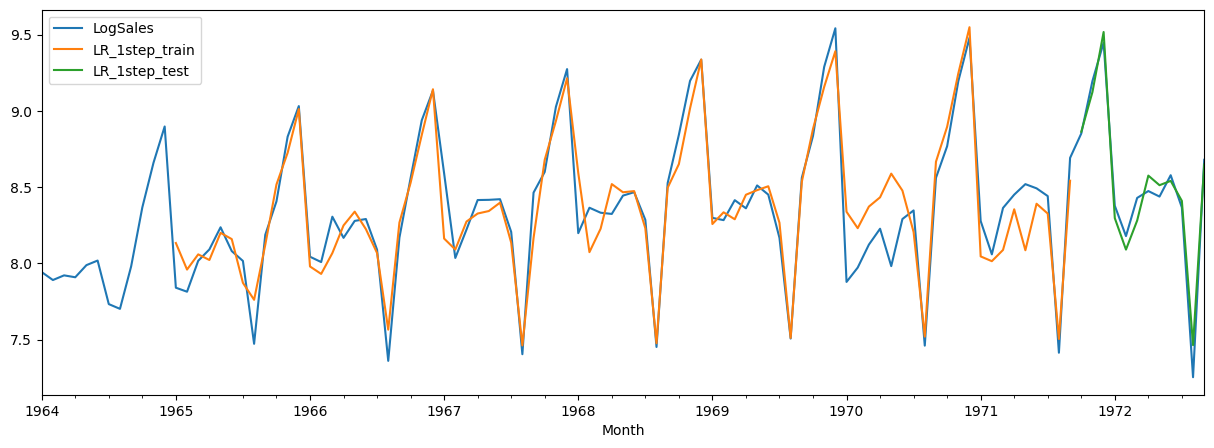

In [13]:
df[["LogSales", "LR_1step_train", "LR_1step_test"]].plot(figsize=(15, 5))


In [14]:
# multi-step forecast
multistep_predictions = []

# first test input
last_x = Xtest[0]

while len(multistep_predictions) < Ntest:
    p = lr.predict(last_x.reshape(1, -1))[0]  # 1x1 array -> scalar
    multistep_predictions.append(p)

    # make the new input
    last_x = np.roll(last_x, -1)
    last_x[-1] = p


In [15]:
# save multi-step forecast to dataframe
df.loc[test_idx, "LR_multistep"] = multistep_predictions


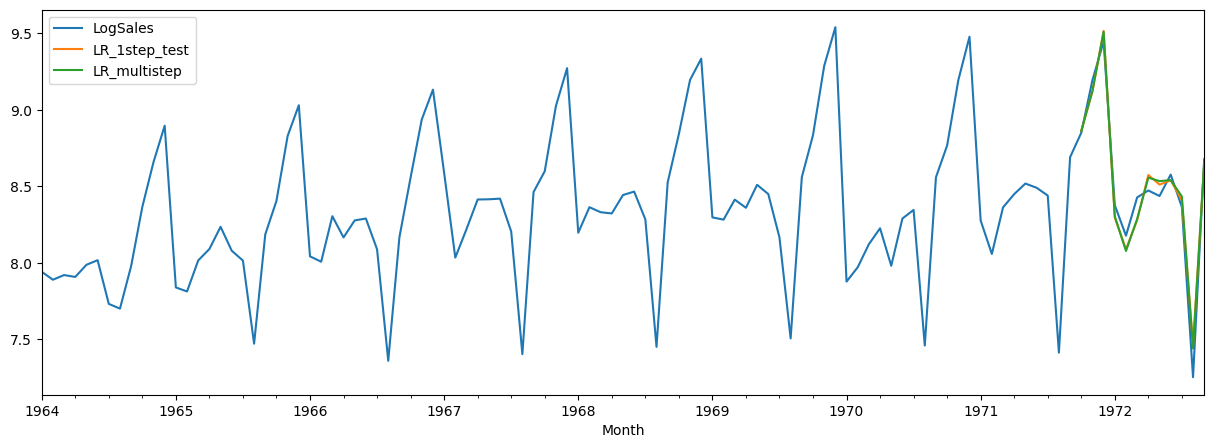

In [16]:
# plot 1-step and multi-step forecasts
df[["LogSales", "LR_1step_test", "LR_multistep"]].plot(figsize=(15, 5))


In [17]:
# make multi-output supervised dataset
Tx = T
Ty = Ntest
X, Y = [], []
for t in range(len(series) - Tx - Ty + 1):
    x = series[t:t+Tx]
    X.append(x)
    y = series[t+Tx:t+Tx+Ty]
    Y.append(y)

X = np.array(X).reshape(-1, Tx)
Y = np.array(Y).reshape(-1, Ty)
N = len(X)
print("X.shape:", X.shape, "Y.shape:", Y.shape)

X.shape: (82, 12) Y.shape: (82, 12)


In [18]:
Xtrain_m, Ytrain_m = X[:-1], Y[:-1]
Xtest_m, Ytest_m = X[-1:], Y[-1:]

In [19]:
lr = LinearRegression()
lr.fit(Xtrain_m, Ytrain_m)
print("LR train score:", lr.score(Xtrain_m, Ytrain_m))

LR train score: 0.8829262390390559


In [20]:
r2_score(lr.predict(Xtest_m).flatten(), Ytest_m.flatten())

0.9595107879158427

In [21]:
# save multi-output forecast to dataframe
df.loc[test_idx, "LR_multioutput"] = lr.predict(Xtest_m).flatten()

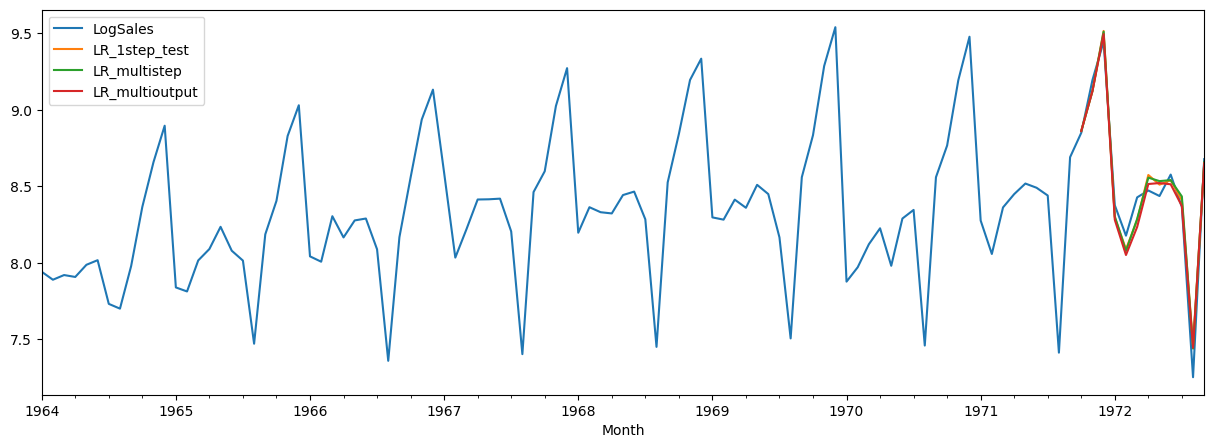

In [22]:
# plot 1-step, multi-step and multi-output forecasts
cols = ["LogSales", "LR_1step_test", "LR_multistep", "LR_multioutput"]
df[cols].plot(figsize=(15, 5));

In [24]:
# MAPE
mape1 = mean_absolute_percentage_error(Ytest, multistep_predictions)
print("multi-step MAOE:", mape1)
mape2 = mean_absolute_percentage_error(Ytest, df.loc[test_idx, "LR_multioutput"])
print("multi-output MAOE:", mape2)

multi-step MAOE: 0.009607169373797656
multi-output MAOE: 0.009727020853255868


## Test Other Models

In [25]:
def one_step_and_multistep_forecast(model, name):
    model.fit(Xtrain, Ytrain)
    print("One-step forecast:", name)
    # print("Train R^2:", model.score(Xtrain, Ytrain))
    # print("Test R^2 (1-step):", model.score(Xtest, Ytest))

    # store 1-step forecast
    df.loc[train_idx, f"{name}_1step_train"] = model.predict(Xtrain)
    df.loc[test_idx, f"{name}_1step_test"] = model.predict(Xtest)

    # generate multi-step forecast
    multistep_predictions = []

    # first test input
    last_x = Xtest[0]

    while len(multistep_predictions) < Ntest:
        p = model.predict(last_x.reshape(1, -1))[0]

        # update the predictions list
        multistep_predictions.append(p)

        # make the new input
        last_x = np.roll(last_x, -1)
        last_x[-1] = p

    df.loc[test_idx, f"{name}_multistep_test"] = multistep_predictions

    # MAPE of multi-step forecast
    mape = mean_absolute_percentage_error(Ytest, multistep_predictions)
    print("Test MAPE (multi-step):", mape)

    # plot 1-step and multi-step forecast
    cols = ["LogSales", f"{name}_1step_train", f"{name}_1step_test", f"{name}_multistep_test"]
    df[cols].plot(figsize=(15, 5));

One-step forecast: SVR
Test MAPE (multi-step): 0.013188370472848127


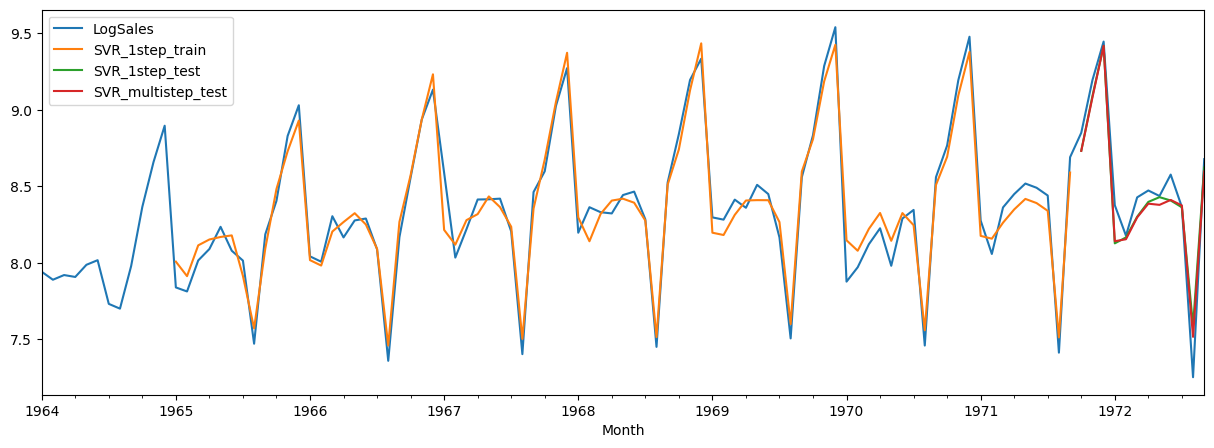

In [26]:
one_step_and_multistep_forecast(SVR(), "SVR")

One-step forecast: RF
Test MAPE (multi-step): 0.010971990036924313


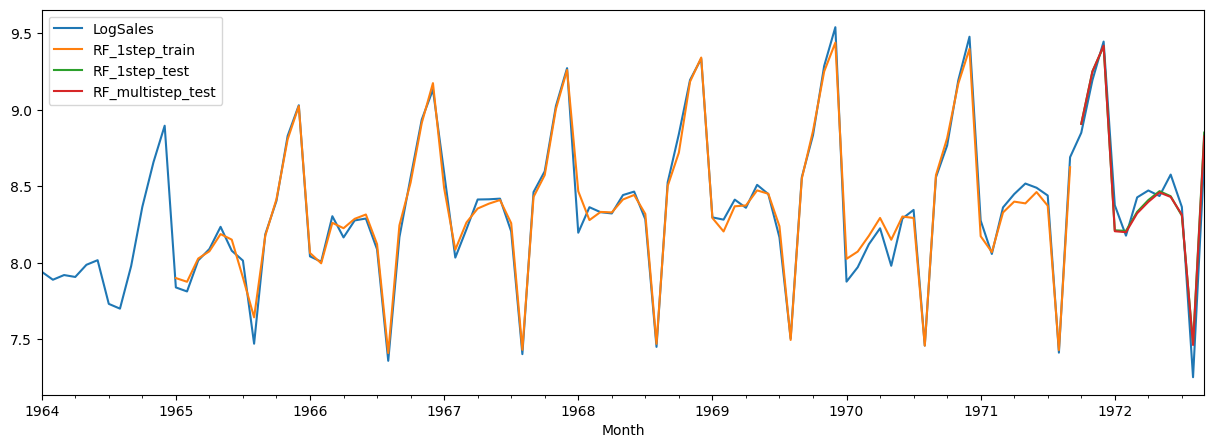

In [27]:
one_step_and_multistep_forecast(RandomForestRegressor(), "RF")

In [28]:
def multi_output_forecast(model, name):
    model.fit(Xtrain_m, Ytrain_m)

    # save multi-output forecast to dataframe
    df.loc[test_idx, f"{name}_multioutput"] = model.predict(Xtest_m).flatten()

    mape = mean_absolute_percentage_error(Ytest, df.loc[test_idx, f"{name}_multioutput"])
    print("Test MAPE (multi-output):", mape)

    # plot all forecasts
    # assume that previous functions have been run
    cols = ["LogSales", f"{name}_1step_train", f"{name}_1step_test", f"{name}_multistep_test", f"{name}_multioutput"]
    df[cols].plot(figsize=(15,5));

In [29]:
# multi_output_forecast(SVR(), "SVR")  # cann't handle multi-output

Test MAPE (multi-output): 0.019082662696702144


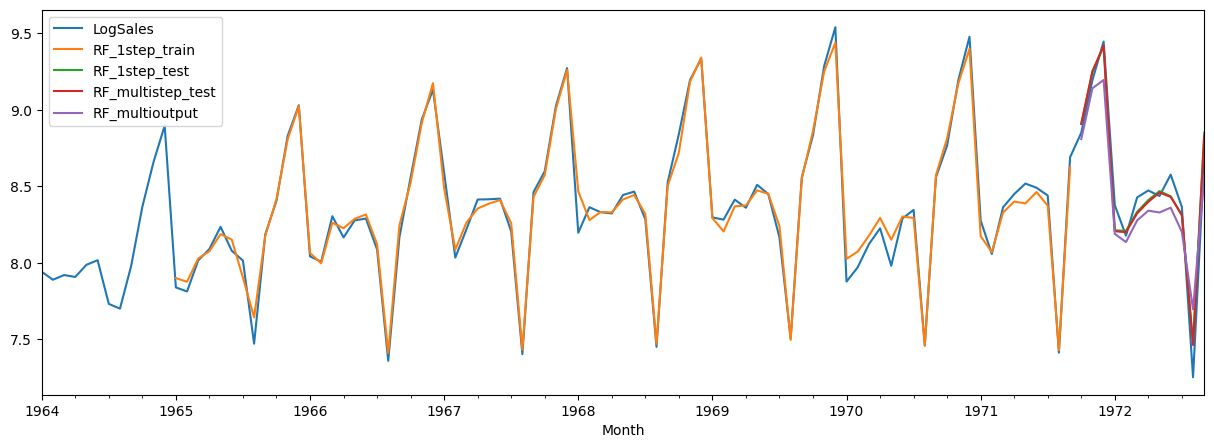

In [30]:
multi_output_forecast(RandomForestRegressor(), "RF")

In [ ]:
# Exercise: compute MAPE for non-logged data (i.e. exponentiate predictions)
# Compare with previous models (e.g. ARIMA, ETS)

# Exercise: does differencing help?